# Perceptrón aplicado al corpus y tarea Iris

### 1. Lectura del corpus

Cargamos el corpus Iris y comprobamos que las matrices de datos `X` y etiquetas `y` contienen el número de filas y columnas que esperamos.

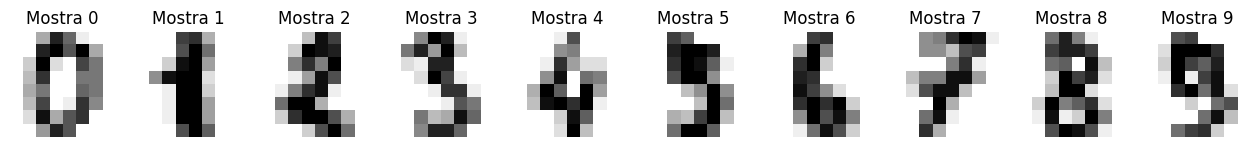

In [4]:
import numpy as np;
import matplotlib.pyplot as plt;
from sklearn.datasets import load_digits;
digits = load_digits();
X = digits.data.astype(np.float16);
y = digits.target.astype(np.uint).reshape(-1, 1);

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(16, 16))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
    ax.set_title("Mostra {!s}".format(label))

### 2. Partición del corpus

Creamos un split del dataset iris con un $20\%$ de datos (30 muestras) para evaluación (*test*), y el resto (120 muestras) para entrenamiento (*training*), barajando previamente los datos de acuerdo con una semilla dada para la generación de números aleatorios.

Aquí, como en todo código que incluya aleatoriedad (que requiera generar números aleatorios), conviene fijar dicha semilla para poder reproducir experimentos posteriormente con exactitud. En este caso, usaremos como semilla un objeto `int` con valor 23.

In [5]:
from sklearn.model_selection import train_test_split
# esta función realiza la partición dandole el porcentaje de datos que meteremos en el test,
# si queremos que baraje y le podemos pasar una semilla para que baraje de manera predeterminada(random state)
X_train, X_test, y_train, y_test = \
       train_test_split(X, y,
                        test_size=0.2,
                        shuffle=True,
                        random_state=23)
print("X_train.shape =", X_train.shape, "; X_test.shape =", X_test.shape)
print("y_train.shape =", y_train.shape, "; y_test.shape =", y_test.shape)

X_train.shape = (1437, 64) ; X_test.shape = (360, 64)
y_train.shape = (1437, 1) ; y_test.shape = (360, 1)


### 3. Implementación del algoritmo Perceptrón

Implementación del algoritmo de aprendizaje Perceptrón, partiendo de pesos nulos.

Recibe como parámetros de entrada:

- Matriz de muestras de entrenamiento `X`, de tamaño $N\times D$,
- Matriz (vector columna) de etiquetas de clase `y`, de tamaño $N\times 1$,
- Valores de los hiperparámetros del algoritmo (a optimizar de manera experimental):
    - Variable de margen `b` $\ge 0$,
    - Factor de aprendizaje `a` $> 0$,
    - Número máximo de iteraciones `K` $> 0$.

Devuelve:

- Matriz de pesos optimizados `W`, en notación homogénea, de tamaño $(1+D)\times C$,  
- Número de muestras de train incorrectamente clasificadas `E` durante la última iteración realizada,
- Número de iteraciones ejecutadas `k`.

In [6]:
def perceptron(X, y, b=0.1, a=1.0, K=200):        # @ = multiplicar matrices y devuelve un escalar
    N, D = X.shape;                               # N: num. muestras; D: dimensionalidad
    Y = np.unique(y);                             # Y: Conjunto etiquetas de clase
    C = Y.size;                                   # C: número de clases
    W = np.zeros((1+D, C));                       # Inicialización matriz de pesos nulos
    for k in range(1, K+1):
        E = 0                                     # E: Contador de errores de clasificación
        for n in range(N):
            xn = np.array([1, *X[n, :]]);         # xn: vector x en notación compacta (el *de *X[N,:] es para descommpactar la fila extraida de X, que se extrae la fila que toque segun n)
            yn = np.squeeze(np.where(Y==y[n]));   # yn: etiq. de clase correcta en {0,...,C-1} (coge el valor que corresponda en el array de Y para usar su posición, no su nombre)
            gn = W[:,yn] @ xn;                    # gn: valor f.discr. de la clase correcta (W_dos(traspuesta) * x_zero)
            err = False;
            for c in np.arange(C):
                if c != yn:
                    if W[:,c] @ xn + b >= gn:     # ¿Se clasifica mal la muestra xn?
                        W[:, c] = W[:, c] - a*xn; # Ajustamos pesos de la clase incorrecta
                        err = True;
            if err:
                W[:, yn] = W[:, yn] + a*xn;       # Ajustamos pesos de la clase correcta
                E = E + 1;
        if E == 0:                                # Algoritmo converge, finalizamos entrenamiento.
            break;
    return W, E, k


**Nota 1:** el carácter `*` delante de una secuencia actúa como [operador de desempaquetado (unpacking operator)]((https://peps.python.org/pep-0448/)).

**Nota 2:** el [operador `@`](https://peps.python.org/pep-0465/) denota multiplicación de matrices.

Conviene resaltar que **el valor `E` devuelto no nos sirve para calcular la tasa de error de train**, ya que los pesos se modifican a lo largo de la iteración. La tasa de error en train se debe calcular con unos pesos fijos (invariables) para todas las muestras, p.e. al finalizar el entrenamiento, o incluso al final de cada iteración. `E` solo nos sirve para conocer el número de actualizaciones de pesos realizadas en la última iteración del algoritmo.

### 4. Aprendizaje de un clasificador lineal con Perceptrón

Perceptrón devuelve una matriz de pesos optimizados $\mathbf{W}^*$ que minimiza el número de errores de entrenamiento (con margen `b`):

$$\mathbf{W}^*=\operatorname*{argmin}_{\mathbf{W}=(\boldsymbol{w}_1,\dotsc,\boldsymbol{w}_C)}\sum_n\;\mathbb{I}\biggl(\max_{c\neq y_n}\;(\boldsymbol{w}_c^t\boldsymbol{x}_n+b) \;>\; \boldsymbol{w}_{y_n}^t\boldsymbol{x}_n\biggr)$$

In [7]:
W, E, k = perceptron(X_train, y_train, K=100);
print("Número de iteraciones ejecutadas: ", k);
print("Número de errores de entrenamiento durante la última iteración: ", E);
print("Vectores de pesos de las clases (por columnas, notación homogénea):\n", W);

Número de iteraciones ejecutadas:  100
Número de errores de entrenamiento durante la última iteración:  10
Vectores de pesos de las clases (por columnas, notación homogénea):
 [[-1.420e+02 -2.120e+02 -1.420e+02 -1.430e+02 -1.050e+02 -1.470e+02
  -1.390e+02 -1.420e+02 -1.450e+02 -1.900e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-1.700e+01 -2.600e+01  3.300e+01  5.000e+01 -3.500e+01 -1.600e+01
  -4.200e+01  4.100e+01 -5.700e+01 -1.680e+02]
 [-8.910e+02 -1.026e+03 -9.100e+02 -9.170e+02 -8.440e+02 -5.140e+02
  -1.030e+03 -8.680e+02 -8.030e+02 -9.180e+02]
 [-1.639e+03 -1.508e+03 -1.635e+03 -1.692e+03 -2.120e+03 -1.821e+03
  -1.746e+03 -1.546e+03 -1.806e+03 -1.448e+03]
 [-1.708e+03 -2.380e+03 -1.691e+03 -1.320e+03 -1.808e+03 -1.682e+03
  -1.757e+03 -1.602e+03 -1.699e+03 -1.571e+03]
 [-1.084e+03 -4.870e+02 -9.800e+02 -9.140e+02 -1.275e+03 -6.720e+02
  -1.110e+03 -8.810e+02 -1.076e+03 -1.022e+03]
 [-3.240e+02 -2.860

### 5. Cálculo de tasas de error

**Tasa de error en train:**

In [8]:
# Matriz de muestras de train en notación homogénea:
X_train_h = np.hstack([np.ones((len(X_train), 1)), X_train]);
# Clasificamos muestras de test, obtenemos etiquetas:
y_train_pred  = np.argmax(X_train_h @ W, axis=1).reshape(-1, 1);
#print(np.hstack([y_train_pred,y_train]))   imprime la comparación entre el predicho y el original


# Calculamos tasa error en train:
err_train = np.count_nonzero(y_train_pred != y_train) / len(X_train);
print(f"Tasa de error en train: {err_train:.1%}");

Tasa de error en train: 1.6%


**Tasa de error en test:**

In [9]:
X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test]);
y_test_pred  = np.argmax(X_test_h @ W, axis=1).reshape(-1, 1); #devuelve un array de a que clase pertenece cada objeto segun nuestro perceptrón

err_test = np.count_nonzero(y_test_pred != y_test) / len(X_test);
print(f"Tasa de error en test: {err_test:.1%}");

Tasa de error en test: 5.3%


**Interpretación de resultados:** $\;$ los datos de entrenamiento no parecen linealmente separables (el algoritmo no converge). Con margen $b=0.1$ se obtiene un error de clasificación en train de $17.5%$ y en test del $26.7\%$. Esto indica que el clasificador evaluado no generaliza bien (funciona significativamente peor con muestras no vistas en entrenamiento). Cabe matizar que se dispone de muy pocas muestras de test (30), por lo que los resultados pueden ser poco representativos o fiables.

### 6. Optimización de hiperparámetros

**Ajuste del margen:** $\;$ experimento para optimizar el valor del hiperparámetro $b$

In [ ]:
print("# {:>8s}\t{:>2s}\t{:>4s}\t{:>13s}\t{:>13s}".format("b", "E", "k","ERROR TRAIN","ERROR TEST"));
for b in (.0, .01, .1, 10, 100, 1000,1300):
    W, E, k = perceptron(X_train, y_train, b=b, K=100)

    X_train_h = np.hstack([np.ones((len(X_train), 1)), X_train]);
    y_train_pred  = np.argmax(X_train_h @ W, axis=1).reshape(-1, 1);
    err_train = np.count_nonzero(y_train_pred != y_train) / len(X_train);

    X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test]);
    y_test_pred  = np.argmax(X_test_h @ W, axis=1).reshape(-1, 1);
    err_test = np.count_nonzero(y_test_pred != y_test) / len(X_test);

    print("  {:8.2f}\t{:>2d}\t{:>4d}\t{:13.2f}\t{:13.2f} ".format(b, E, k,err_train,err_test));

#        b	 E	   k	  ERROR TRAIN	   ERROR TEST
      0.00	 9	 100	         0.10	         0.17 
      0.01	 9	 100	         0.10	         0.17 
      0.10	11	 100	         0.17	         0.27 
     10.00	 8	 100	         0.09	         0.17 
    100.00	17	 100	         0.06	         0.07 
   1000.00	45	 100	         0.03	         0.00 
   1300.00	50	 100	         0.04	         0.00 


In [12]:
err_test_minimo = [1,0,0,0]
err_train_minimo = [1,0,0,0]


print("# {:>8s}\t{:>2s}\t{:>2s}\t{:>2s}\t{:>4s}\t{:>13s}\t{:>13s}".format("b","a","k_aux", "E", "k","ERROR TRAIN","ERROR TEST"));
for b in (.0, .01, .1, 1, 10, 100, 1000,1300):
    for a in (0.85,0.90,0.95,1):
      for k_aux in (100, 200, 300):
        W, E, k = perceptron(X_train, y_train, b=b, a=a, K=k_aux)

        X_train_h = np.hstack([np.ones((len(X_train), 1)), X_train]);
        y_train_pred  = np.argmax(X_train_h @ W, axis=1).reshape(-1, 1);
        err_train = np.count_nonzero(y_train_pred != y_train) / len(X_train);

        if err_train < err_train_minimo[0]:
          err_train_minimo = [err_train,b,a,k_aux]

        X_test_h = np.hstack([np.ones((len(X_test), 1)), X_test]);
        y_test_pred  = np.argmax(X_test_h @ W, axis=1).reshape(-1, 1);
        err_test = np.count_nonzero(y_test_pred != y_test) / len(X_test);

        if err_test < err_test_minimo[0]:
          err_test_minimo = [err_test,b,a,k_aux]

        print("  {:8.2f}\t{:>2.2f}\t{:>2d}\t{:>2d}\t{:>4d}\t{:13.4f}\t{:13.4f} ".format(b,a,k_aux, E, k,err_train,err_test));

print("\nel error de test mínimo ha sido de {:5%} con un nos valores de BETA, ALPHA y K de : {:.3f}, {:.2f} y {:4d}".format(err_test_minimo[0],err_test_minimo[1],err_test_minimo[2],err_test_minimo[3]))
print("el error de entrenamiento mínimo ha sido de {:5%} con un nos valores de BETA, ALPHA y K de : {:.3f}, {:.2f} y {:4d}".format(err_train_minimo[0],err_train_minimo[1],err_train_minimo[2],err_train_minimo[3]))

#        b	 a	k_aux	 E	   k	  ERROR TRAIN	   ERROR TEST
      0.00	0.85	100	 0	  70	       0.0000	       0.0417 
      0.00	0.85	200	 0	  70	       0.0000	       0.0417 
      0.00	0.85	300	 0	  70	       0.0000	       0.0417 
      0.00	0.90	100	 0	  80	       0.0000	       0.0472 
      0.00	0.90	200	 0	  80	       0.0000	       0.0472 
      0.00	0.90	300	 0	  80	       0.0000	       0.0472 
      0.00	0.95	100	 0	  85	       0.0000	       0.0500 
      0.00	0.95	200	 0	  85	       0.0000	       0.0500 
      0.00	0.95	300	 0	  85	       0.0000	       0.0500 
      0.00	1.00	100	10	 100	       0.0160	       0.0528 
      0.00	1.00	200	 0	 106	       0.0000	       0.0444 
      0.00	1.00	300	 0	 106	       0.0000	       0.0444 
      0.01	0.85	100	10	 100	       0.0160	       0.0528 
      0.01	0.85	200	 0	 106	       0.0000	       0.0444 
      0.01	0.85	300	 0	 106	       0.0000	       0.0444 
      0.01	0.90	100	10	 100	       0.0160	       0.0528 
      0.01	0.90	200	 0	 106	    

Viendo esta tabla, con el número de errores en entrenamiento acaecidos durante la última iteración, no podemos extraer conclusiones. Deberíamos evaluar la tasa de error en test (y quizás también en train) para determinar el valor de `b` óptimo (que permite generalizar mejor).

Como regla general, **seleccionaremos el conjunto de valores de hiperparámetros que minimicen la tasa de error en test**.

### 7. Ejercicios

1. Modifica la celda de código anterior para que calcule las tasas de error en train y test para cada experimento y las muestre en la tabla de resultados, añadiendo sendas columnas adicionales.
2. A partir de la información proporcionada por las tasas de error en train y test, determina cuál es el valor de `b` óptimo. Puedes ampliar la exploración con otros valores de `b`, para tratar de optimizar aún más la tasa de error.
3. Explora también diferentes valores para los hiperparámetros `a` y `K`. En esta tarea tan pequeña y sencilla no tienen un gran impacto, pero su exploración en otras tareas puede proporcionar mejoras adicionales, especialmente con `K` cuando el algoritmo no converge (¿cuándo es mejor parar el entrenamiento?).  